To deal with the large number of Category, Title and Entity maybe its worth looking into if they are related i.e. does one Title imply that the ad will be of a particular Category. Similiarly, does the Ad being of a particular Entity imply that it will be of a particular Category. For this I am using Contigency table and Chi-square test (refernce: http://hamelg.blogspot.com/2015/11/python-for-data-analysis-part-25-chi.html)

In [20]:
# Imports
# pandas
import pandas as pd
from pandas import Series,DataFrame
# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import gc
import seaborn as sns
p = sns.color_palette()
%matplotlib inline

<b>Topics</b>

In [21]:
try:del events
except:pass;gc.collect()

topics = pd.read_csv('./data/documents_topics.csv')
print('Columns:',topics.columns.tolist())
print('Number of unique topics:', len(topics.topic_id.unique()))

topics.head()

('Columns:', ['document_id', 'topic_id', 'confidence_level'])
('Number of unique topics:', 300)


,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


Number of topics that appear more than 10000 times: 201
Number of topics that appear more than 50000 times: 86
Number of topics that appear more than 100000 times: 22
Number of topics that appear more than 200000 times: 3


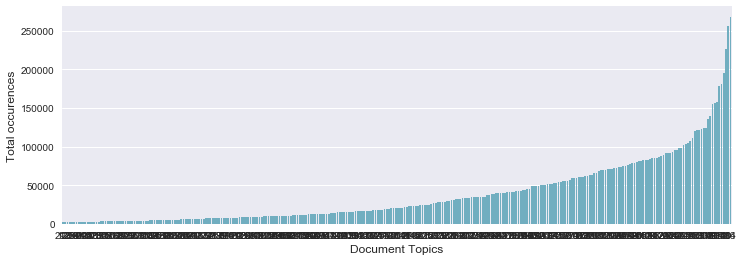

In [22]:
topic_ids = topics.groupby('topic_id')['confidence_level'].count().sort_values()

for i in [10000, 50000, 100000, 200000]:
    print('Number of topics that appear more than {} times: {}'
          .format(i, (topic_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(topic_ids.index, topic_ids.values, order=topic_ids.index, alpha=1, color=p[5])
plt.xlabel('Document Topics', fontsize=12)
plt.ylabel('Total occurences', fontsize=12)
plt.show()
del(topic_ids)

Should we just consider topics who occur may be more than lets say 100000 times (like we did for words in the Naive Bayes classifier?) OR should we check if topics (and entities) are correlated with categories. If they are then we can ignore them since categories would act as their proxy.

<b>Categories</b>

In [24]:
categories = pd.read_csv('./data/documents_categories.csv',  dtype={"document_id": int})

In [ ]:
print('Columns:', categories.columns.tolist())
print('Number of unique categories:', len(categories.category_id.unique()))

cat_ids = categories.groupby('category_id')['confidence_level'].count().sort_values()

for i in [1000, 10000, 50000, 100000]:
    print('Number of categories that appear more than {} times: {}'
          .format(i, (cat_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(cat_ids.index, cat_ids.values, order=cat_ids.index, alpha=1, color=p[3])
plt.xlabel('Document Categories', fontsize=12)
plt.ylabel('Total occurences', fontsize=12)
plt.show()

<b>Entities</b>

In [ ]:
print('Columns:', entities.columns.tolist())
print('Number of unique categories:', len(entities.category_id.unique()))

cat_ids = entities.groupby('entity_id')['confidence_level'].count().sort_values()

for i in [1000, 10000, 50000, 100000]:
    print('Number of categories that appear more than {} times: {}'
          .format(i, (cat_ids > i).sum()))

plt.figure(figsize=(12, 4))
sns.barplot(cat_ids.index, cat_ids.values, order=cat_ids.index, alpha=1, color=p[3])
plt.xlabel('Document Entities', fontsize=12)
plt.ylabel('Total occurences', fontsize=12)
plt.show()

In [26]:
def confidence_max(topics):
    topics_grouped = topics.groupby(['document_id'], sort=False).agg({'confidence_level':'max'})
    topics_grouped = topics_grouped.reset_index()
    topics_grouped = topics_grouped.rename(columns={'confidence_level':'confidence_max'})
    topics_grouped = topics_grouped.drop_duplicates(subset=['document_id'])
    topics = pd.merge(topics, topics_grouped, how='left', on=['document_id'])
    del(topics_grouped)
    topics = topics[topics['confidence_level'] == topics['confidence_max']]
    topics.drop('confidence_level', axis=1, inplace=True)
    topics.drop('confidence_max', axis=1, inplace=True)
    topics = topics.drop_duplicates(subset=['document_id'])
    return topics

In [27]:
topics = confidence_max(topics)

In [28]:
topics.head()

,document_id,topic_id
0,1595802,140
4,1524246,113
10,1617787,113
16,1615583,89
18,1615460,260


In [29]:
categories = confidence_max(categories)

In [31]:
categories.category_id = categories.category_id.apply(str)

In [32]:
topics.topic_id = topics.topic_id.apply(str)

In [12]:
categories.shape

(2828649, 2)

In [13]:
topics.shape

(2495423, 2)

In [33]:
topics.head()

,document_id,topic_id
0,1595802,140
4,1524246,113
10,1617787,113
16,1615583,89
18,1615460,260


In [34]:
# Outerjoin
topics_cat = pd.merge(topics, categories, how='outer', left_on = 'document_id', right_on = 'document_id')

In [ ]:
del(topics)

In [36]:
cat_dummies = pd.get_dummies(topics_cat.category_id).to_sparse(fill_value=0)

In [41]:
topics_cat.drop('category_id', axis=1, inplace=True)

In [42]:
topics_cat.drop('document_id', axis=1, inplace=True)

In [43]:
topics_cat = pd.concat([topics_cat, cat_dummies], axis=1, join='inner')

In [ ]:
del(cat_dummies)

In [ ]:
topics_cat = topics_cat.groupby(by='topic_id', sort=False).agg(sum).reset_index()

In [ ]:
topics_cat.head()

In [ ]:
stats.chi2_contingency(topics_cat)

In [ ]:
entities = pd.read_csv('./data/documents_entities.csv',  dtype={"document_id": int})
entities = confidence_max(entities)

In [ ]:
entities_cat = pd.merge(entities, categories, how='outer', left_on = 'document_id', right_on = 'document_id')

In [ ]:
del(entities)

In [ ]:
cat_dummies = pd.get_dummies(entities_cat.category_id).to_sparse(fill_value=0)

In [ ]:
entities_cat.drop('category_id', axis=1, inplace=True)

In [ ]:
entities_cat.drop('document_id', axis=1, inplace=True)

In [ ]:
entities_cat = pd.concat([entities_cat, cat_dummies], axis=1, join='inner')

In [ ]:
del(cat_dummies)

In [ ]:
topics_cat = topics_cat.groupby(by='topic_id', sort=False).agg(sum).reset_index()

In [ ]:
stats.chi2_contingency(topics_cat)